<a href="https://colab.research.google.com/github/OscarAlvaradoM/Introduccion-al-Aprendizaje-Profundo/blob/main/tarea2/Tarea2_P1_IAP_OscarAlvardo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 2

Resuelve los siguientes ejercicios en libretas de Colab independientes que sean replicables.

## Descarga de algunas cosas importantes para el entorno

In [ ]:
# biblioteca para inspeccionar arquitecturas
# https://github.com/tyleryep/torchinfo
!pip install torchinfo

## Bibliotecas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take

import torch
import torch.nn as nn # Esta no sé

import torch.optim as optim # Esta no sé
import torch.nn.functional as F  # Esta no sé

import torchvision
import torchvision.transforms as T # Esta no sé
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# inspección de arquitectura
from torchinfo import summary
# barras de progreso
from tqdm import trange

## Resolución de un bicho de Colab

In [ ]:
# parche para bicho en colab
# https://github.com/pytorch/vision/issues/1938
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

## Inicialización del dispositivo GPU

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Ejercicio 1
Diseña y entrena una red convolucional para el conjunto de datos CIFAR10. Explora diferentes diseños buscando mejorar tus resultados en el ejercicio 4 de la tarea 1. Discute tus resultados.

### Directorios y funciones útiles para despliegue de imágenes

In [ ]:
DATA_DIR = './data'

BATCH_SIZE = 32
# filas y columnas de la regilla de imágenes
ROWS, COLS = 4, 8


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i])
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # aplanamos canal
    x = x.reshape(*x.shape)
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)

    
def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    
# reproducibilidad
set_seed()

### Descarga de los datos

In [ ]:
# creamos un Dataset
ds = CIFAR10(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=True, 
    # convertir la imagen a ndarray
    transform=np.array, 
    # descargar el conjunto
    download=True
)


Extracting ./data/cifar-10-python.tar.gz to ./data


### Despliegue de algunos ejemplos

images[0] shape=(32, 32, 3) dtype=uint8


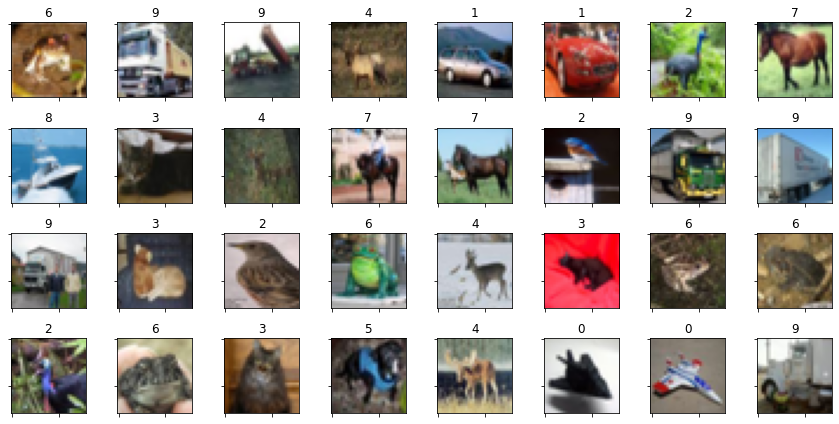

In [ ]:
# cargamos algunas imágenes
images, labels = [], []
for i in range(BATCH_SIZE):
    x, y = ds[i]
    images.append(x)
    labels.append(y)

# desplegamos
print(f'images[0] shape={images[0].shape} dtype={images[0].dtype}')
titles = [str(y) for y in labels]
display_grid(images, titles, ROWS, COLS)

### Conjunto de entrenamiento. Despliegue de ejemplos

x shape=torch.Size([32, 3, 32, 32]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


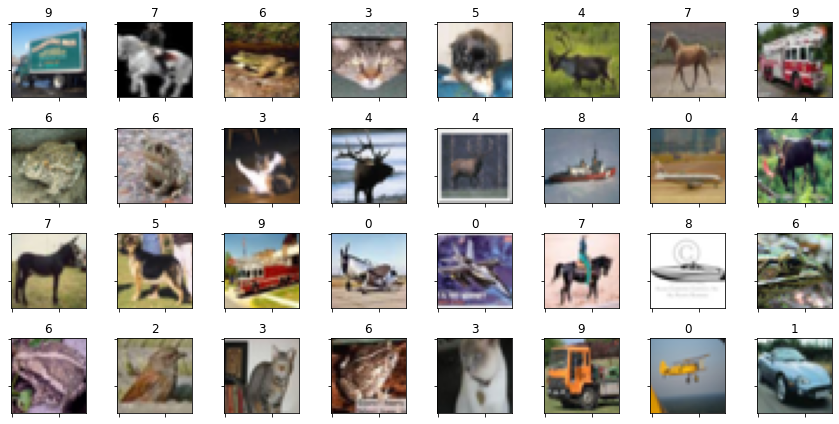

In [ ]:
# transformación que convierte una imagen:
#   de numpy.ndarray    (H x W x C) en rango [0, 255]
#   a torch.FloatTensor (C x H x W) en rango [0, 1]
tsfm = T.ToTensor()

# creamos un Dataset
trn_ds = CIFAR10(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, y.tolist(), ROWS, COLS)

### Conjunto de pruebas y despliegue de algunos ejemplos


x shape=torch.Size([32, 3, 32, 32]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


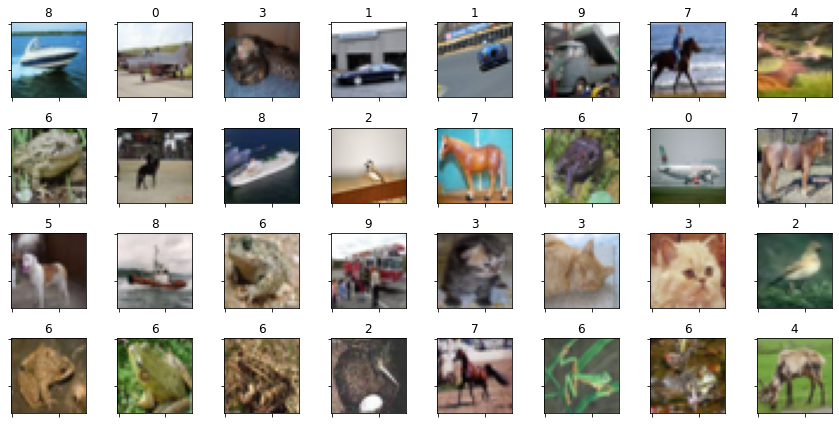

In [ ]:
# creamos un Dataset
tst_ds = CIFAR10(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=False,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
tst_dl = DataLoader(
    # subconjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(tst_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, y.tolist(), ROWS, COLS)

### Definición de la arquitectura

In [ ]:
# Definición de arquitectura
class CNN(nn.Module):
    
    # inicializador
    def __init__(self):

        # inicilización del objeto padre, obligatorio
        super(CNN, self).__init__()
        # Valores iniciales
        h_i1 = 32; w_i1 = 32; c_i1 = 3
        
        # Convolución 1
        c_o1=15; filter_size1=4; fill1=1; step1=1
        h_o1 = int((h_i1 - filter_size1 + 2*fill1)/step1) + 1
        w_o1 = int((w_i1 - filter_size1 + 2*fill1)/step1) + 1
        
        # Pool 1
        filter_size_pool1=2; step_pool1=1
        h_o1 = int((h_o1 - filter_size_pool1)/step_pool1) + 1
        w_o1 = int((w_o1 - filter_size_pool1)/step_pool1) + 1
        c_o_pool1 = c_o1
        
        h_i2=h_o1; w_i2=w_o1; c_i2=c_o_pool1
        
        # Convolución 2
        c_o2=18; filter_size2=3; fill2=1; step2=1
        h_o2 = int((h_i2 - filter_size2 + 2*fill2)/step2) + 1
        w_o2 = int((w_i2 - filter_size2 + 2*fill2)/step2) + 1
        
        # Pool 1
        filter_size_pool2 = 2; step_pool2 = 1
        h_o2 = int((h_o2 - filter_size_pool2)/step_pool2) + 1
        w_o2 = int((w_o2 - filter_size_pool2)/step_pool2) + 1
        c_o_pool2 = c_o2
        
        h_i3=h_o2; w_i3=w_o2; c_i3=c_o_pool2
        
        # Convolución 3
        c_o3=21; filter_size3=2; fill3=2; step3=1
        h_o3 = int((h_i3 - filter_size3 + 2*fill3)/step3) + 1
        w_o3 = int((w_i3 - filter_size3 + 2*fill3)/step3) + 1
        
        # Pool 3
        filter_size_pool3 = 2; step_pool3 = 1
        h_o3 = int((h_o3 - filter_size_pool3)/step_pool3) + 1
        w_o3 = int((w_o3 - filter_size_pool3)/step_pool3) + 1
        c_o_pool3 = c_o3
        
        
        # definición de bloques conv
        self.cnn = nn.Sequential(
            # Convolución 1
            nn.Conv2d(in_channels=c_i1, out_channels=c_o1, 
                      kernel_size=filter_size1, padding=fill1, stride=step1),
            # Activación 1
            nn.ReLU(),
            # Pool 1
            nn.MaxPool2d(kernel_size=filter_size_pool1, stride=step_pool1),

            # Convolución 2
            nn.Conv2d(in_channels=c_i2, out_channels=c_o2, 
                      kernel_size=filter_size2, padding=fill2, stride=step2),
            # Activación 2
            nn.ReLU(),
            # Pool 2
            nn.MaxPool2d(kernel_size=filter_size_pool2, stride=step_pool2),
            
            # # Convolución 3
            # nn.Conv2d(in_channels=c_i3, out_channels=c_o3, 
            #           kernel_size=filter_size3, padding=fill3, stride=step3),
            # # Activación 3
            # nn.ReLU(),
            # # Pool 3
            # nn.MaxPool2d(kernel_size=filter_size_pool3, stride=step_pool3),

        )       
        self.num_feats = c_o_pool2 * h_o2 * w_o2
        self.flatten = nn.Flatten()
        self.cls = nn.Linear(self.num_feats, 10)
    
    # metodo para inferencia
    def forward(self, x):
        x = self.cnn(x)
        x = self.flatten(x)
        x = self.cls(x)
        return x

#### Instanciamiento de un modelo

In [ ]:
model = CNN()
print(model)

CNN(
  (cnn): Sequential(
    (0): Conv2d(3, 15, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(15, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cls): Linear(in_features=15138, out_features=10, bias=True)
)


#### Probando con datos artificales

In [ ]:
# inferencia con datos sintéticos
x = torch.zeros(1, 3, 32, 32)
y = model(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 3, 32, 32]) => torch.Size([1, 10])


In [ ]:
summary(model, (1,3, 32, 32), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      --                        --
├─Sequential: 1-1                        [1, 18, 29, 29]           --
│    └─Conv2d: 2-1                       [1, 15, 31, 31]           735
│    └─ReLU: 2-2                         [1, 15, 31, 31]           --
│    └─MaxPool2d: 2-3                    [1, 15, 30, 30]           --
│    └─Conv2d: 2-4                       [1, 18, 30, 30]           2,448
│    └─ReLU: 2-5                         [1, 18, 30, 30]           --
│    └─MaxPool2d: 2-6                    [1, 18, 29, 29]           --
├─Flatten: 1-2                           [1, 15138]                --
├─Linear: 1-3                            [1, 10]                   151,390
Total params: 154,573
Trainable params: 154,573
Non-trainable params: 0
Total mult-adds (M): 3.09
Input size (MB): 0.01
Forward/backward pass size (MB): 0.24
Params size (MB): 0.62
Estimated Total Size (MB): 0.88

### Modelo paralelo

In [ ]:
def train_epoch_GPU(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        
        # computamos logits
        y_lgts = model(x.to(device))
        
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true.to(device))
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch_GPU(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x.to(device))

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true.to(device))

            # computamos la exactitud
            acc = (y_true.to(device) == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train_GPU(model, trn_dl, tst_dl, lr=1e-3, epochs=20,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch_GPU(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch_GPU(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch_GPU(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

### Instanciamiento y entrenamiento del modelo.

In [ ]:
%%time
# instanciamos un modelo
model = CNN()
# entrenamos
#loss_hist, acc_hist = train(model, trn_dl, tst_dl)
loss_hist, acc_hist = train_GPU(model.to(device), trn_dl, tst_dl, epochs=40)

  2%|▎         | 1/40 [00:14<09:08, 14.07s/it]

E00 loss=[199.23,198.56] acc=[28.50,29.46]


  5%|▌         | 2/40 [00:27<08:52, 14.01s/it]

E01 loss=[185.54,185.08] acc=[36.09,37.01]


  8%|▊         | 3/40 [00:41<08:37, 13.99s/it]

E02 loss=[174.02,173.63] acc=[39.91,40.40]


 10%|█         | 4/40 [00:55<08:22, 13.96s/it]

E03 loss=[163.08,162.57] acc=[43.11,42.87]


 12%|█▎        | 5/40 [01:09<08:07, 13.92s/it]

E04 loss=[156.30,156.12] acc=[45.10,44.84]


 15%|█▌        | 6/40 [01:23<07:53, 13.93s/it]

E05 loss=[153.42,153.27] acc=[46.57,46.25]


 18%|█▊        | 7/40 [01:37<07:39, 13.92s/it]

E06 loss=[148.38,148.60] acc=[48.22,47.75]


 20%|██        | 8/40 [01:51<07:25, 13.91s/it]

E07 loss=[150.15,150.91] acc=[47.17,47.01]


 22%|██▎       | 9/40 [02:05<07:11, 13.91s/it]

E08 loss=[144.69,145.55] acc=[48.43,48.01]


 25%|██▌       | 10/40 [02:19<06:56, 13.90s/it]

E09 loss=[141.25,142.45] acc=[50.36,49.98]


 28%|██▊       | 11/40 [02:33<06:43, 13.91s/it]

E10 loss=[138.39,139.57] acc=[51.59,50.85]


 30%|███       | 12/40 [02:47<06:30, 13.94s/it]

E11 loss=[134.35,136.15] acc=[52.70,51.80]


 32%|███▎      | 13/40 [03:01<06:16, 13.95s/it]

E12 loss=[129.35,131.52] acc=[55.25,53.45]


 35%|███▌      | 14/40 [03:14<06:01, 13.92s/it]

E13 loss=[128.26,131.02] acc=[55.53,53.82]


 38%|███▊      | 15/40 [03:28<05:47, 13.90s/it]

E14 loss=[127.56,130.41] acc=[56.02,54.53]


 40%|████      | 16/40 [03:42<05:33, 13.92s/it]

E15 loss=[123.69,126.93] acc=[56.70,54.84]


 42%|████▎     | 17/40 [03:56<05:19, 13.89s/it]

E16 loss=[123.50,127.06] acc=[57.22,55.25]


 45%|████▌     | 18/40 [04:10<05:06, 13.91s/it]

E17 loss=[120.37,124.21] acc=[58.16,55.81]


 48%|████▊     | 19/40 [04:24<04:52, 13.91s/it]

E18 loss=[117.82,121.97] acc=[59.15,57.09]


 50%|█████     | 20/40 [04:38<04:38, 13.94s/it]

E19 loss=[118.22,122.57] acc=[58.32,56.31]


 52%|█████▎    | 21/40 [04:52<04:24, 13.93s/it]

E20 loss=[118.08,122.89] acc=[58.85,56.81]


 55%|█████▌    | 22/40 [05:06<04:10, 13.90s/it]

E21 loss=[118.69,123.86] acc=[58.40,56.06]


 57%|█████▊    | 23/40 [05:20<03:56, 13.90s/it]

E22 loss=[114.86,119.70] acc=[60.36,58.15]


 60%|██████    | 24/40 [05:34<03:42, 13.92s/it]

E23 loss=[111.15,116.41] acc=[61.77,58.82]


 62%|██████▎   | 25/40 [05:47<03:29, 13.93s/it]

E24 loss=[115.98,121.78] acc=[59.48,57.30]


 65%|██████▌   | 26/40 [06:01<03:14, 13.91s/it]

E25 loss=[109.79,115.81] acc=[61.98,59.61]


 68%|██████▊   | 27/40 [06:15<03:00, 13.90s/it]

E26 loss=[108.97,115.48] acc=[62.22,59.06]


 70%|███████   | 28/40 [06:29<02:46, 13.91s/it]

E27 loss=[108.38,114.98] acc=[62.58,59.72]


 72%|███████▎  | 29/40 [06:43<02:33, 13.94s/it]

E28 loss=[106.81,113.74] acc=[63.14,60.63]


 75%|███████▌  | 30/40 [06:57<02:19, 13.95s/it]

E29 loss=[106.24,113.56] acc=[63.26,60.17]


 78%|███████▊  | 31/40 [07:11<02:05, 13.90s/it]

E30 loss=[105.01,112.82] acc=[63.43,60.42]


 80%|████████  | 32/40 [07:25<01:51, 13.89s/it]

E31 loss=[110.72,118.78] acc=[60.77,58.09]


 82%|████████▎ | 33/40 [07:39<01:37, 13.89s/it]

E32 loss=[103.20,111.30] acc=[64.54,60.61]


 85%|████████▌ | 34/40 [07:53<01:23, 13.93s/it]

E33 loss=[105.72,114.22] acc=[63.07,59.75]


 88%|████████▊ | 35/40 [08:07<01:09, 13.95s/it]

E34 loss=[105.73,114.57] acc=[63.03,59.90]


 90%|█████████ | 36/40 [08:21<00:55, 13.93s/it]

E35 loss=[101.42,110.45] acc=[64.92,61.56]


 92%|█████████▎| 37/40 [08:35<00:41, 13.99s/it]

E36 loss=[102.82,112.20] acc=[64.46,60.78]


 95%|█████████▌| 38/40 [08:49<00:27, 13.94s/it]

E37 loss=[ 99.37,109.10] acc=[65.86,62.11]


 98%|█████████▊| 39/40 [09:02<00:13, 13.92s/it]

E38 loss=[100.52,110.33] acc=[65.14,61.49]


100%|██████████| 40/40 [09:16<00:00, 13.92s/it]

E39 loss=[ 99.03,109.31] acc=[65.83,61.92]
CPU times: user 8min 48s, sys: 26.9 s, total: 9min 15s
Wall time: 9min 16s


### Resultados

#### 2 capas convolucionales, 40 épocas

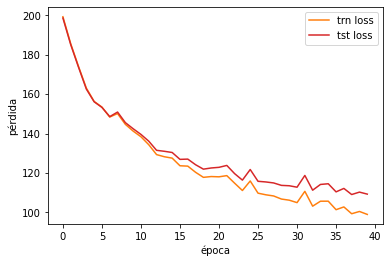

In [ ]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

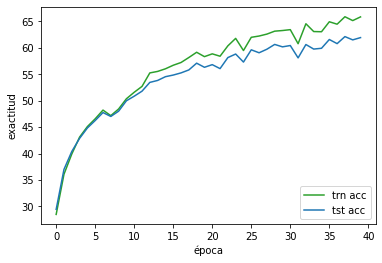

In [ ]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

In [ ]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch_GPU(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch_GPU(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[ 99.04,109.42] acc=[65.84,61.85]


#### 2 capas convolucionales, 20 épocas

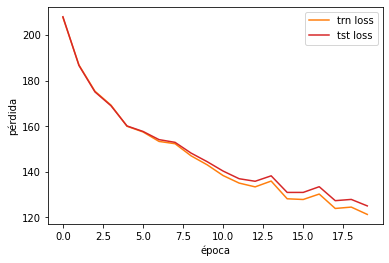

In [ ]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

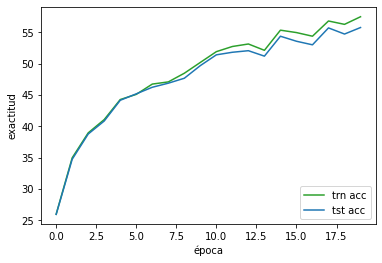

In [ ]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

In [ ]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch_GPU(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch_GPU(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[121.30,125.02] acc=[57.49,55.77]


#### 3 capas convolucionales, 40 épocas

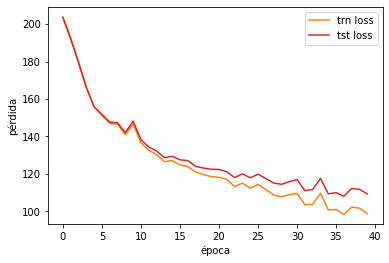

In [ ]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

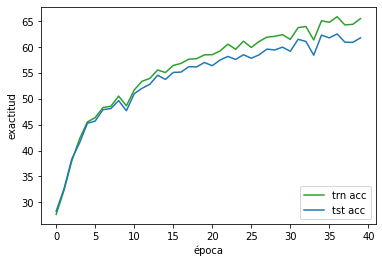

In [ ]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

In [ ]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch_GPU(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch_GPU(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[ 98.76,109.48] acc=[65.55,61.77]


#### 3 capas convolucionales, 20 épocas

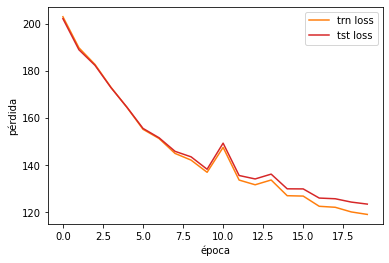

In [ ]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

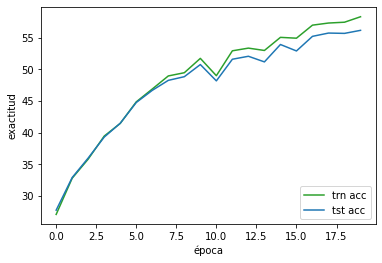

In [ ]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

### Evaluación en entrenamiento

In [ ]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch_GPU(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch_GPU(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[119.16,123.63] acc=[58.31,56.15]


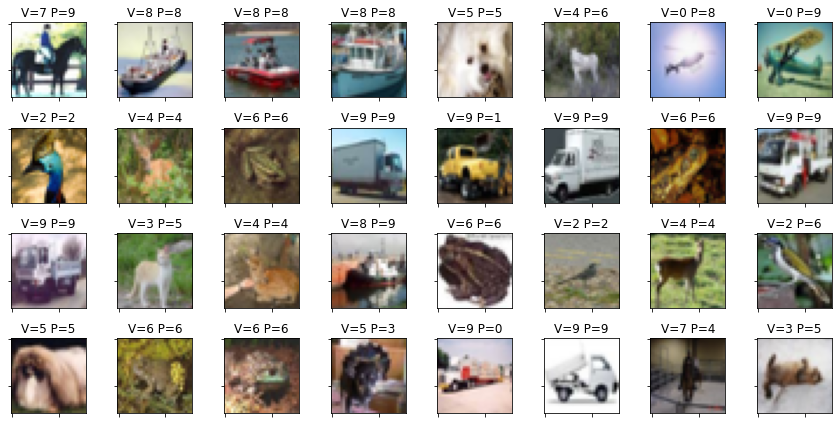

In [ ]:
with torch.no_grad(): 
    x, y_true = next(iter(tst_dl))
    y_lgts = model(x.to(device)).to(device)
    y_prob = F.softmax(y_lgts, 1)
    y_pred = torch.argmax(y_prob, 1)
    titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
    display_batch(x, titles, ROWS, COLS)

### Conclusiones

Se probaron diferentes aarquitecturas para esa red, en especial con varias capas de convoluciones. Sin mucho éxito, los mejores resultados fueron obtenidos con dos capas convolucionales. Se obtuvieron mejores resultados que con las redes neuronales profundas y con menor tiempo de ejecución en el mismo dispositivo. A continuación se muestran los hiperparámetros para los mejores resultados que se obtuvieron, todos mejores que los resultados de la tarea anterior. Los mejores resultados obtenidos para la tarea anterior fueron:\
loss=[119.41,140.41] acc=[57.09,50.51] con 40 épocas.

Parecía que lo que más afectaba a los resultados era que el tamaño de la salida (es decir, el número de filtros) fuera más grande, así como que al añadir más capas se fuera haciendo más grande aún.

### Resultados numéricos

#### Una capa
Filtros: 9\
Tamaño del filtro: 4\
Relleno de las orillas: 1\
Paso de recorrido convolucional: 1\
Tamaño del filtro del MaxPooling: 2\
Paso del filtro del MaxPooling: 1\
Resultados alcanzados:\
loss=[124.25,127.12] acc=[57.45,56.19] con 20 épocas\
loss=[110.71,118.92] acc=[61.97,58.55] con 40 épocas

#### Dos capas
- Primera capa\
Filtros: 15\
Tamaño del filtro: 4\
Relleno de las orillas: 1\
Paso de recorrido convolucional: 1\
Tamaño del filtro del MaxPooling: 2\
Paso del filtro del MaxPooling: 1\
- Segunda capa\
Filtros: 18\
Tamaño del filtro: 3\
Relleno de las orillas: 1\
Paso de recorrido convolucional: 1\
Tamaño del filtro del MaxPooling: 2\
Paso del filtro del MaxPooling: 1\
Resultados alcanzados: \
loss=[118.74,123.05] acc=[58.46,56.43] con 20 épocas\
loss=[ 99.03,109.31] acc=[65.83,61.92] con 40 épocas

#### Tres capas
- Primera capa\
Filtros: 15\
Tamaño del filtro: 4\
Relleno de las orillas: 1\
Paso de recorrido convolucional: 1\
Tamaño del filtro del MaxPooling: 2\
Paso del filtro del MaxPooling: 1
- Segunda capa\
Filtros: 18\
Tamaño del filtro: 3\
Relleno de las orillas: 1\
Paso de recorrido convolucional: 1\
Tamaño del filtro del MaxPooling: 2\
Paso del filtro del MaxPooling: 1
- Tercer capa\
Filtros: 21\
Tamaño del filtro: 2\
Relleno de las orillas: 2\
Paso de recorrido convolucional: 1\
Tamaño del filtro del MaxPooling: 2\
Paso del filtro del MaxPooling: 1\
Resultados alcanzados: \
loss=[119.16,123.53] acc=[58.31,56.16] con 20 épocas\
loss=[ 98.76,109.30] acc=[65.56,61.83] con 40 épocas